# INFOMATION

### python info
 - Version : 3.6.10
 - Anaconda ver 4.8.2
 
### package info
 - tensorflow ver 2.1.0
 - numpy ver 1.19.1
 - pandas ver 1.1.1

In [1]:
# ##########################################
# # 환경 변경 또는 다운로드를 원할때 사용하세요
# # 전체를 드래그 후 ctrl+/ 누르면 활성화 됩니다.
# !pip install tensorflow==2.1
# !pip install numpy==1.19.1
# !pip install pandas==1.1.1
# !pip install varname
# !pip install qgrid
# !pip install pymysql
# ##########################################

# tensorflow
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

import os

# data array
import pandas as pd
from datetime import datetime, date
import numpy as np

# print 내 지수표현식 방지
np.set_printoptions(formatter={'float_kind': lambda x: "{0:0.2f}".format(x)})

# nomalization
from sklearn.preprocessing import MinMaxScaler as scaler
from sklearn.metrics import mean_squared_error

# return variable name
from varname import nameof

# dataframe visualization
import qgrid

- matplotlib 오류 방지

In [2]:
import matplotlib
if "DISPLAY" not in os.environ:
    # remove Travis CI Error
    matplotlib.use('TkAgg')

import matplotlib.pyplot as plt
%matplotlib inline

# SETTING
 ### function

In [3]:
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series) - seq_length):
        x = time_series[i : i + seq_length,:-1]
        y = time_series[i + seq_length, [-1]]

        dataX.append(x)
        dataY.append(y)
        if i <=10:
            print('{}번째'.format(i))
            print(x, "->", y)
            print('='*10)
            
    return np.array(dataX), np.array(dataY)

def build_dataset_x(time_series, seq_length):
    dataX = []
    for i in range(0, len(time_series) - seq_length):
        x = time_series[i : i + seq_length,:]
        dataX.append(x)
        if i <=10:
            print('{}번째'.format(i))
            print(x)
            print('='*10)
    return np.array(dataX)

def series_diff(data, data_col, start_date, mid_date, end_date, col):
    cfm_date = list(data['cfm_date'])
    date_idx = pd.to_datetime(cfm_date)
    
    prd_data = data[data_col]
    prd_data = pd.DataFrame(np.array(prd_data), columns=data_col, index=date_idx)
    
    mid_date_ = date.fromisoformat(mid_date)
    next_mid_date = mid_date_.replace(day=mid_date_.day + 1).isoformat()
    
    # prd_data = prd_data.loc[start_date:end_date,col]
    # start_idx = prd_data.index.searchsorted(datetime.strptime(start_date,'%Y-%m-%d'))
    # mid_idx = prd_data.index.searchsorted(datetime.strptime(mid_date,'%Y-%m-%d'))
    # mid_mext_idx = mid_idx + 1
    # end_idx = prd_data.index.searchsorted(datetime.strptime(end_date,'%Y-%m-%d'))
    # next_mid_date = prd_data.iloc[mid_].index()

    diff_polyfit = prd_data.loc[start_date:mid_date,col]
    diff_prd = prd_data.loc[next_mid_date:end_date,col]
    
    return prd_data, diff_polyfit, diff_prd


def polyfit_prd(diff_polyfit, diff_prd, col, periods = 0):
    nd_diff_polyfit = np.array(diff_polyfit)
    nd_diff_prd = np.array(diff_prd)
    
    diff_polyfit = pd.DataFrame(diff_polyfit,columns=[col])
    diff_prd = pd.DataFrame(diff_prd,columns=[col])
    
    polyfit = np.polyfit(np.arange(0,nd_diff_polyfit.shape[0]),nd_diff_polyfit,1)
    
    def f(x):
        dataX=[]
        for i in x:
            if i > 0:
                dataX.append(i)
            else:
                dataX.append(0)
        
        return dataX
    
    poly_inv = polyfit[0]  \
                * np.arange(0,nd_diff_polyfit.shape[0]) \
                + polyfit[1]
    poly_inv = f(poly_inv)
    
    prd_fit = polyfit[0]  \
                * np.arange(nd_diff_polyfit.shape[0],nd_diff_polyfit.shape[0]+nd_diff_prd.shape[0]) \
                + polyfit[1]
    prd_fit = f(prd_fit)
    
    list_prd = polyfit[0]  \
                * np.arange(nd_diff_polyfit.shape[0]+nd_diff_prd.shape[0],
                            nd_diff_polyfit.shape[0]+nd_diff_prd.shape[0]+periods) \
                + polyfit[1]
    list_prd = f(list_prd)
    
    print(prd_fit,'\n',list_prd,'\n',list_prd)
    w, b = polyfit # weight, bias
    print('{} 추세선 값  = w :  {}/ b : {}'.format(col, w, b))
    
    diff_prd['prd_{}'.format(col)] = np.array(prd_fit)
    
    diff_polyfit['prd_{}'.format(col)] = np.array(poly_inv)
    
    return diff_prd, diff_polyfit, list_prd

### parameter

In [4]:
# train Parameters
seq_length = 4
data_dim = 3
output_dim = 1
learning_rate = 0.001
iterations = 1000

# Preprocess Data
 - load data

In [5]:
try:
    
    import pymysql

    col_name = ['cfm_date','symptom','asymptom','research','cfm_cnt','exam_cnt','policy']
    col_name_str = ','.join(col_name)
    sql_gginfo_select = "select {} from GGInternal".format(col_name_str)

    conn = pymysql.connect(
        user='root', 
        passwd='1234', 
        host='127.0.0.1', 
        db='covid19', 
        charset='utf8'
    )

    with conn.cursor() as cur:
        print('connect complete')
        cur.execute(sql_gginfo_select)
        data = cur.fetchall()


        data = pd.DataFrame(data,columns=col_name)

    spd_symptom = 3.5
    spd_asymptom = 0.8

    data['spread'] = data['symptom'] * (spd_symptom * 0.01) + data['asymptom'] * (spd_asymptom * 0.01)

    xy = data[['cfm_date','exam_cnt','spread','policy','cfm_cnt']]
    
    
    

except:
    print('DB 접속 실패')
    data = pd.read_csv('test_0918_both.csv')
    
    data['spread'] = data['symptom'] * (spd_symptom * 0.01) + data['asymptom'] * (spd_asymptom * 0.01)

    xy = data[['cfm_date','exam_cnt','spread','policy','cfm_cnt']]

    
qgrid.show_grid(xy,show_toolbar=True)

connect complete


QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

- 시계열 컬럼 삭제 및 부동소수점으로 변환

In [6]:
try:
    del xy['cfm_date']
except:
    del xy['date']

xy = xy.values.astype(np.float)
# xy = xy[::-1]  # reverse order (chronically ordered) <- already reverse

- 데이터 시각화

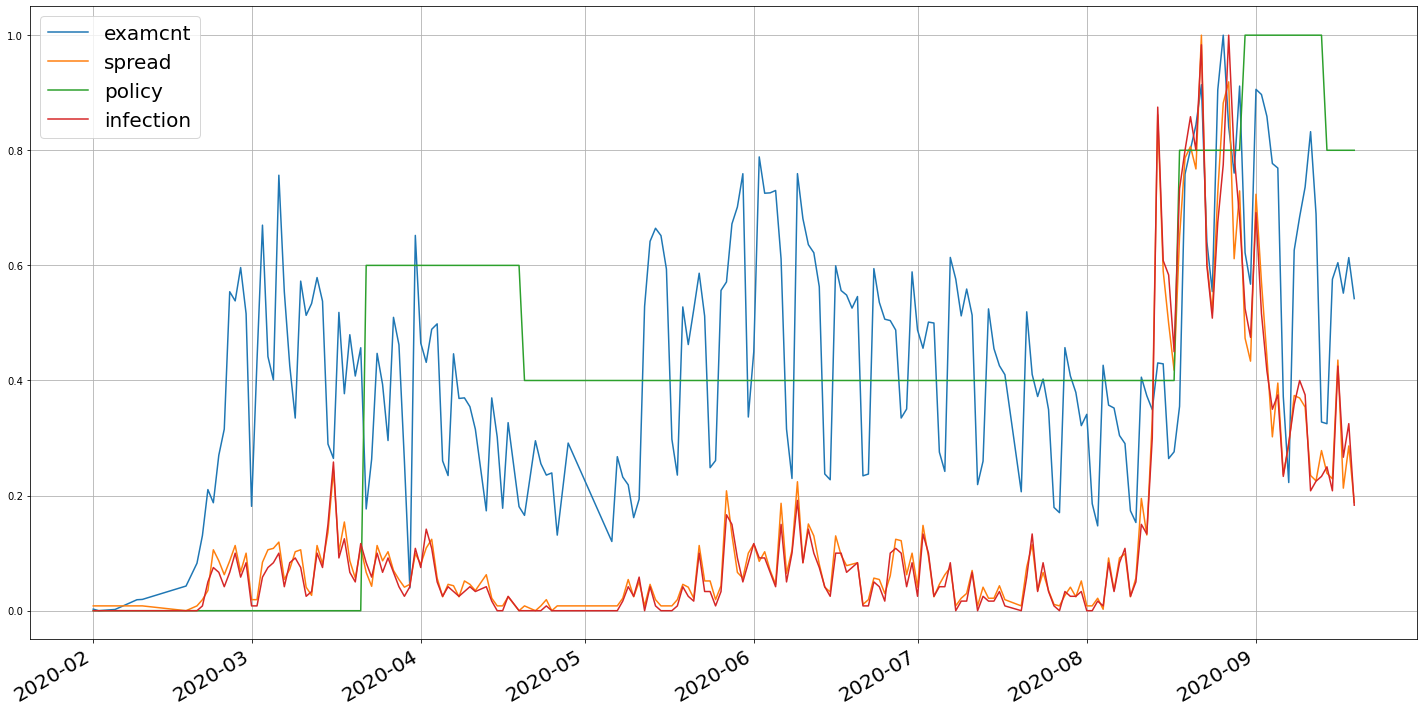

In [7]:
scal = scaler()
scal_tf = scal.fit_transform(xy)
try:
    ts_xy = pd.DataFrame(scal_tf).set_index(data['cfm_date'])
except:
    ts_xy = pd.DataFrame(scal_tf, index = data['date'])
    

plt.figure(figsize=(20,10))
plt.plot(pd.to_datetime(ts_xy.index,format='%Y-%m-%d'),ts_xy[0], linestyle='-', marker=None, label = 'examcnt')
plt.plot(pd.to_datetime(ts_xy.index,format='%Y-%m-%d'),ts_xy[1], linestyle='-', marker=None, label = 'spread')
plt.plot(pd.to_datetime(ts_xy.index,format='%Y-%m-%d'),ts_xy[2], linestyle='-', marker=None, label = 'policy')
plt.plot(pd.to_datetime(ts_xy.index,format='%Y-%m-%d'),ts_xy[3], linestyle='-', marker=None, label = 'infection')
plt.xticks(rotation=90)
plt.xticks(fontsize=20)
plt.grid(b=True, axis='both', linestyle='-')
plt.legend(loc='upper left',fontsize = 20)


plt.gcf().autofmt_xdate()
plt.tight_layout()

plt.show()

- 학습용 / 테스트용 분리

In [8]:
size_rate = 0.95
train_size = int(len(xy) * size_rate)
train_set = xy[0:train_size]
test_set = xy[train_size - seq_length:]
train_set

array([[119.00, 0.04, 0.00, 1.00],
       [55.00, 0.04, 0.00, 1.00],
       [105.00, 0.04, 0.00, 1.00],
       [498.00, 0.04, 0.00, 1.00],
       [512.00, 0.04, 0.00, 1.00],
       [1053.00, 0.01, 0.00, 1.00],
       [1976.00, 0.04, 0.00, 1.00],
       [3098.00, 0.07, 0.00, 2.00],
       [4957.00, 0.12, 0.00, 7.00],
       [4424.00, 0.35, 0.00, 10.00],
       [6346.00, 0.29, 0.00, 9.00],
       [7404.00, 0.21, 0.00, 6.00],
       [12965.00, 0.29, 0.00, 9.00],
       [12594.00, 0.37, 0.00, 13.00],
       [13944.00, 0.23, 0.00, 8.00],
       [12075.00, 0.33, 0.00, 11.00],
       [4280.00, 0.07, 0.00, 2.00],
       [10194.00, 0.07, 0.00, 2.00],
       [15660.00, 0.28, 0.00, 8.00],
       [10340.00, 0.35, 0.00, 10.00],
       [9396.00, 0.36, 0.00, 11.00],
       [17681.00, 0.39, 0.00, 13.00],
       [12966.00, 0.18, 0.00, 6.00],
       [9962.00, 0.24, 0.00, 11.00],
       [7852.00, 0.34, 0.00, 12.00],
       [13395.00, 0.35, 0.00, 10.00],
       [12009.00, 0.14, 0.00, 4.00],
       [12489.

 - 스케일링 (Min-Max Scaling)
     > 1. x, y 스케일러 인스턴스 생성
     > 2. x, y 전체 피팅 생성
     > 3. 학습용 / 테스트용 스케일링 변환
     >> * 나누는 목적
     >>> 나중에 inverse 할때 예상값과 같은 배열 크기여야 가능하다.

In [9]:
min_max_x = scaler()
min_max_y = scaler()

min_max_x_fit = min_max_x.fit(xy[:,:-1])
min_max_y_fit = min_max_y.fit(xy[:,[-1]])

train_set_sc_x = min_max_x.transform(train_set[:, :-1])
train_set_sc_y = min_max_y.transform(train_set[:, [-1]])
test_set_sc_x = min_max_x.transform(test_set[:, :-1])
test_set_sc_y = min_max_y.transform(test_set[:, [-1]])

print(train_set_sc_x[:10])
print('-'*10)
print(train_set[:10])
print('-'*10)
print(min_max_x.inverse_transform(train_set_sc_x)[:10])

[[0.00 0.01 0.00]
 [0.00 0.01 0.00]
 [0.00 0.01 0.00]
 [0.02 0.01 0.00]
 [0.02 0.01 0.00]
 [0.04 0.00 0.00]
 [0.08 0.01 0.00]
 [0.13 0.02 0.00]
 [0.21 0.03 0.00]
 [0.19 0.11 0.00]]
----------
[[119.00 0.04 0.00 1.00]
 [55.00 0.04 0.00 1.00]
 [105.00 0.04 0.00 1.00]
 [498.00 0.04 0.00 1.00]
 [512.00 0.04 0.00 1.00]
 [1053.00 0.01 0.00 1.00]
 [1976.00 0.04 0.00 1.00]
 [3098.00 0.07 0.00 2.00]
 [4957.00 0.12 0.00 7.00]
 [4424.00 0.35 0.00 10.00]]
----------
[[119.00 0.04 0.00]
 [55.00 0.04 0.00]
 [105.00 0.04 0.00]
 [498.00 0.04 0.00]
 [512.00 0.04 0.00]
 [1053.00 0.01 0.00]
 [1976.00 0.04 0.00]
 [3098.00 0.07 0.00]
 [4957.00 0.12 0.00]
 [4424.00 0.35 0.00]]


 - 원상복귀 시켜준다.

In [10]:
train_set = np.concatenate((train_set_sc_x,train_set_sc_y), axis=1)
test_set = np.concatenate((test_set_sc_x,test_set_sc_y), axis=1)
print(train_set[:3])
print('-'*10)
print(test_set[:3])

[[0.00 0.01 0.00 0.00]
 [0.00 0.01 0.00 0.00]
 [0.00 0.01 0.00 0.00]]
----------
[[0.77 0.40 1.00 0.37]
 [0.37 0.24 1.00 0.23]
 [0.22 0.29 1.00 0.29]]


 - 학습 / 테스트 데이터 구분

In [11]:
print('Data Name is {}'.format(nameof(train_set)))
trainX, trainY = build_dataset(train_set, seq_length)

print('\n\n')

print('Data Name is {}'.format(nameof(test_set)))
testX, testY = build_dataset(test_set, seq_length)

print(trainX.shape,testX.shape)

Data Name is train_set
0번째
[[0.00 0.01 0.00]
 [0.00 0.01 0.00]
 [0.00 0.01 0.00]
 [0.02 0.01 0.00]] -> [0.00]
1번째
[[0.00 0.01 0.00]
 [0.00 0.01 0.00]
 [0.02 0.01 0.00]
 [0.02 0.01 0.00]] -> [0.00]
2번째
[[0.00 0.01 0.00]
 [0.02 0.01 0.00]
 [0.02 0.01 0.00]
 [0.04 0.00 0.00]] -> [0.00]
3번째
[[0.02 0.01 0.00]
 [0.02 0.01 0.00]
 [0.04 0.00 0.00]
 [0.08 0.01 0.00]] -> [0.01]
4번째
[[0.02 0.01 0.00]
 [0.04 0.00 0.00]
 [0.08 0.01 0.00]
 [0.13 0.02 0.00]] -> [0.05]
5번째
[[0.04 0.00 0.00]
 [0.08 0.01 0.00]
 [0.13 0.02 0.00]
 [0.21 0.03 0.00]] -> [0.07]
6번째
[[0.08 0.01 0.00]
 [0.13 0.02 0.00]
 [0.21 0.03 0.00]
 [0.19 0.11 0.00]] -> [0.07]
7번째
[[0.13 0.02 0.00]
 [0.21 0.03 0.00]
 [0.19 0.11 0.00]
 [0.27 0.09 0.00]] -> [0.04]
8번째
[[0.21 0.03 0.00]
 [0.19 0.11 0.00]
 [0.27 0.09 0.00]
 [0.32 0.06 0.00]] -> [0.07]
9번째
[[0.19 0.11 0.00]
 [0.27 0.09 0.00]
 [0.32 0.06 0.00]
 [0.55 0.09 0.00]] -> [0.10]
10번째
[[0.27 0.09 0.00]
 [0.32 0.06 0.00]
 [0.55 0.09 0.00]
 [0.54 0.11 0.00]] -> [0.06]



Data Name is tes

 ### LSTM Modeling
  - 셀 지정

In [12]:
# tf.random.set_seed(777)
tf.model = tf.keras.Sequential()
tf.model.add(tf.keras.layers.LSTM(units=5,input_shape=(seq_length, data_dim), return_sequences=True))
tf.model.add(tf.keras.layers.LSTM(units=5, return_sequences=False))
tf.model.add(tf.keras.layers.Dense(units=output_dim, activation='linear'))
tf.model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 4, 5)              180       
_________________________________________________________________
lstm_1 (LSTM)                (None, 5)                 220       
_________________________________________________________________
dense (Dense)                (None, 1)                 6         
Total params: 406
Trainable params: 406
Non-trainable params: 0
_________________________________________________________________


 - Compile 지정

In [13]:
tf.model.compile(loss='mse',
                 # optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
                 optimizer='adam',
                 metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min',patience = 40)

h = tf.model.fit(trainX, trainY,
                 epochs=iterations,
                 batch_size=7,
                 validation_data=[testX,testY],
                 verbose=1,
                 callbacks = [es]
                )

Train on 191 samples, validate on 11 samples
Epoch 1/1000
191/191 [==============================] - 3s 15ms/sample - loss: 0.0594 - accuracy: 0.1257 - val_loss: 0.0581 - val_accuracy: 0.0000e+00
Epoch 2/1000
191/191 [==============================] - 0s 651us/sample - loss: 0.0445 - accuracy: 0.1257 - val_loss: 0.0356 - val_accuracy: 0.0000e+00
Epoch 3/1000
191/191 [==============================] - 0s 806us/sample - loss: 0.0408 - accuracy: 0.1257 - val_loss: 0.0265 - val_accuracy: 0.0000e+00
Epoch 4/1000
191/191 [==============================] - 0s 911us/sample - loss: 0.0380 - accuracy: 0.1257 - val_loss: 0.0223 - val_accuracy: 0.0000e+00
Epoch 5/1000
191/191 [==============================] - 0s 808us/sample - loss: 0.0342 - accuracy: 0.1257 - val_loss: 0.0207 - val_accuracy: 0.0000e+00
Epoch 6/1000
191/191 [==============================] - 0s 687us/sample - loss: 0.0290 - accuracy: 0.1257 - val_loss: 0.0135 - val_accuracy: 0.0000e+00
Epoch 7/1000
191/191 [======================

191/191 [==============================] - 0s 622us/sample - loss: 0.0078 - accuracy: 0.1309 - val_loss: 0.0081 - val_accuracy: 0.0000e+00
Epoch 55/1000
191/191 [==============================] - 0s 608us/sample - loss: 0.0076 - accuracy: 0.1309 - val_loss: 0.0082 - val_accuracy: 0.0000e+00
Epoch 56/1000
191/191 [==============================] - 0s 565us/sample - loss: 0.0075 - accuracy: 0.1309 - val_loss: 0.0077 - val_accuracy: 0.0000e+00
Epoch 57/1000
191/191 [==============================] - 0s 560us/sample - loss: 0.0075 - accuracy: 0.1309 - val_loss: 0.0084 - val_accuracy: 0.0000e+00
Epoch 58/1000
191/191 [==============================] - 0s 599us/sample - loss: 0.0075 - accuracy: 0.1309 - val_loss: 0.0076 - val_accuracy: 0.0000e+00
Epoch 59/1000
191/191 [==============================] - 0s 599us/sample - loss: 0.0077 - accuracy: 0.1309 - val_loss: 0.0079 - val_accuracy: 0.0000e+00
Epoch 60/1000
191/191 [==============================] - 0s 627us/sample - loss: 0.0075 - accura

 -  Modeling 예측

In [14]:
test_predict = tf.model.predict(testX)
MSE = mean_squared_error(testY.reshape(-1,1),test_predict)
RMSE = np.sqrt(MSE)

pred_score = 100 * ( 1 - (((test_predict - testY)**2).sum())/((testY**2).sum()))

print('MSE : {} , RMSE : {} , score : {}'.format(MSE,RMSE,pred_score))
np.array(min_max_y.inverse_transform(test_predict), dtype=np.int)[:10]

MSE : 0.013476422380534314 , RMSE : 0.11608799412744762 , score : 84.32928127237824


array([[50],
       [56],
       [56],
       [41],
       [33],
       [31],
       [32],
       [39],
       [51],
       [45]])

 - 에러율 검출 시각화 

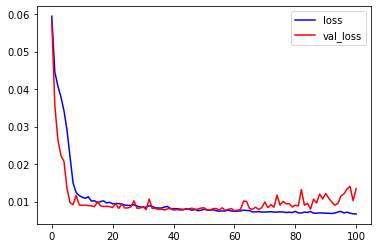

In [15]:
plt.plot(h.history['loss'], label = 'loss', color = 'b')
plt.plot(h.history['val_loss'], label = 'val_loss', color = 'r')
plt.legend()
plt.show()

 - 실제값 vs 예측값 시각화

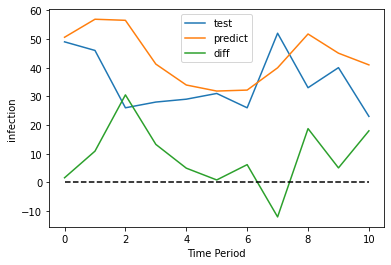

In [16]:
Ty = min_max_y.inverse_transform(testY)
Tp = min_max_y.inverse_transform(test_predict)
Td = Tp - Ty

plt.plot(Ty,label = 'test')
plt.plot(Tp,label = 'predict')
plt.plot(Td,label = 'diff')
plt.plot(np.zeros(len(Td)),'--', color = 'black')
plt.xlabel("Time Period")
plt.ylabel("infection")
plt.legend()
plt.show()

 - 학습 구간 - 예측구간 전체 시각화

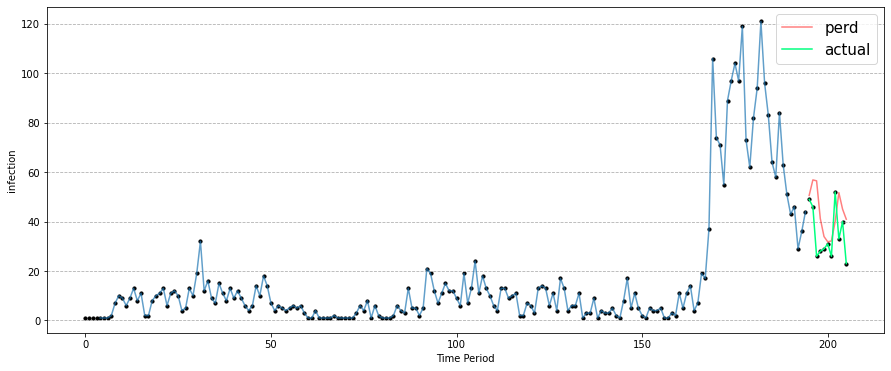

In [17]:
t_axis = np.arange(0,len(xy))
s_axis = np.arange(0,seq_length)
a_axis = np.arange(len(s_axis),len(s_axis) + len(trainY))
b_axis = np.arange(len(s_axis) + len(a_axis),len(s_axis) + len(a_axis) + len(test_predict))

plt.figure(figsize=(15,6))
plt.scatter(t_axis,xy[:,-1],color = 'black',s = 10)
plt.plot(a_axis, min_max_y_fit.inverse_transform(trainY), alpha=0.7)
plt.plot(b_axis,min_max_y_fit.inverse_transform(test_predict), color='red', alpha=0.5, label='perd')
plt.plot(b_axis,min_max_y_fit.inverse_transform(testY), color='springgreen', label='actual')
plt.xlabel("Time Period")
plt.ylabel("infection")
plt.grid(b=True, axis='y', linestyle='--')
plt.legend(fontsize = 15)
plt.show()


 - Modeling Save Point

In [18]:
from datetime import datetime
from tensorflow.keras.models import model_from_json

if pred_score >=90 :
    # Save model
    model_json = tf.model.to_json()
    with open("./model_json/model_{}_score_{}.json".format(datetime.now().strftime('%Y_%m_%d'),int(pred_score*100)), "w") as json_file : 
        json_file.write(model_json)

    # Save model weights
    tf.model.save_weights("./weight_h5/model_weight_{}_score_{}.h5".format(datetime.now().strftime('%Y_%m_%d'),int(pred_score*100)))
    print("Saved model to disk")
    
    # load model model & witght
    json_file = open("./model_json/model_{}_score_{}.json".format(datetime.now().strftime('%Y_%m_%d'),int(pred_score*100)), "r")
    json_model = json_file.read()
    json_file.close()
    model = model_from_json(json_model)
    model.load_weights("./weight_h5/model_weight_{}_score_{}.h5".format(datetime.now().strftime('%Y_%m_%d'),int(pred_score*100)))
    
    
else:
    print('모델 점수가 90점 미만입니다.')

모델 점수가 90점 미만입니다.


### Predict 10days
1. X 데이터 시계열 흐름

In [19]:

data_col = ['exam_cnt', 'spread', 'policy', 'cfm_cnt']
periods = 5

# exam 2020-09-12 ~ 2020-09-19
prd_data, exam_diff_polyfit, exam_diff_prd = series_diff(data = data, data_col = data_col,
                                             start_date = '2020-08-31',mid_date='2020-09-12',
                                             end_date='2020-09-19',
                                             col = data_col[0])

exam_prd_fit, exam_diff_data, exam_list_prd = polyfit_prd(exam_diff_polyfit, exam_diff_prd,
                                                     data_col[0],periods=periods)

# spread
_, spread_diff_polyfit, spread_diff_prd = series_diff(data = data, data_col = data_col,
                                          start_date = '2020-09-07', mid_date='2020-09-12',
                                          end_date='2020-09-19',
                                          col = data_col[1])

spread_prd_fit, spread_diff_data, spread_list_prd = polyfit_prd(spread_diff_polyfit,
                                                         spread_diff_prd,
                                                         data_col[1],
                                                         periods=periods)

policy_list_prd = np.full(periods,2)

arr_prd = np.concatenate((exam_list_prd,spread_list_prd,policy_list_prd),axis=0).reshape(-1,periods).T
print(arr_prd)

qgrid.show_grid(prd_data)

[14592.923076923076, 14381.681318681318, 14170.43956043956, 13959.197802197803, 13747.956043956045, 13536.714285714286, 13325.472527472528] 
 [13114.23076923077, 12902.989010989011, 12691.747252747255, 12480.505494505496, 12269.263736263738] 
 [13114.23076923077, 12902.989010989011, 12691.747252747255, 12480.505494505496, 12269.263736263738]
exam_cnt 추세선 값  = w :  -211.24175824175796/ b : 17339.06593406593
[0.7621999999999998, 0.6938285714285712, 0.6254571428571426, 0.557085714285714, 0.48871428571428543, 0.4203428571428568, 0.35197142857142816] 
 [0.28359999999999963, 0.215228571428571, 0.14685714285714235, 0.07848571428571383, 0.010114285714285298] 
 [0.28359999999999963, 0.215228571428571, 0.14685714285714235, 0.07848571428571383, 0.010114285714285298]
spread 추세선 값  = w :  -0.0683714285714286/ b : 1.1724285714285714
[[13114.23 0.28 2.00]
 [12902.99 0.22 2.00]
 [12691.75 0.15 2.00]
 [12480.51 0.08 2.00]
 [12269.26 0.01 2.00]]


QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

시각화

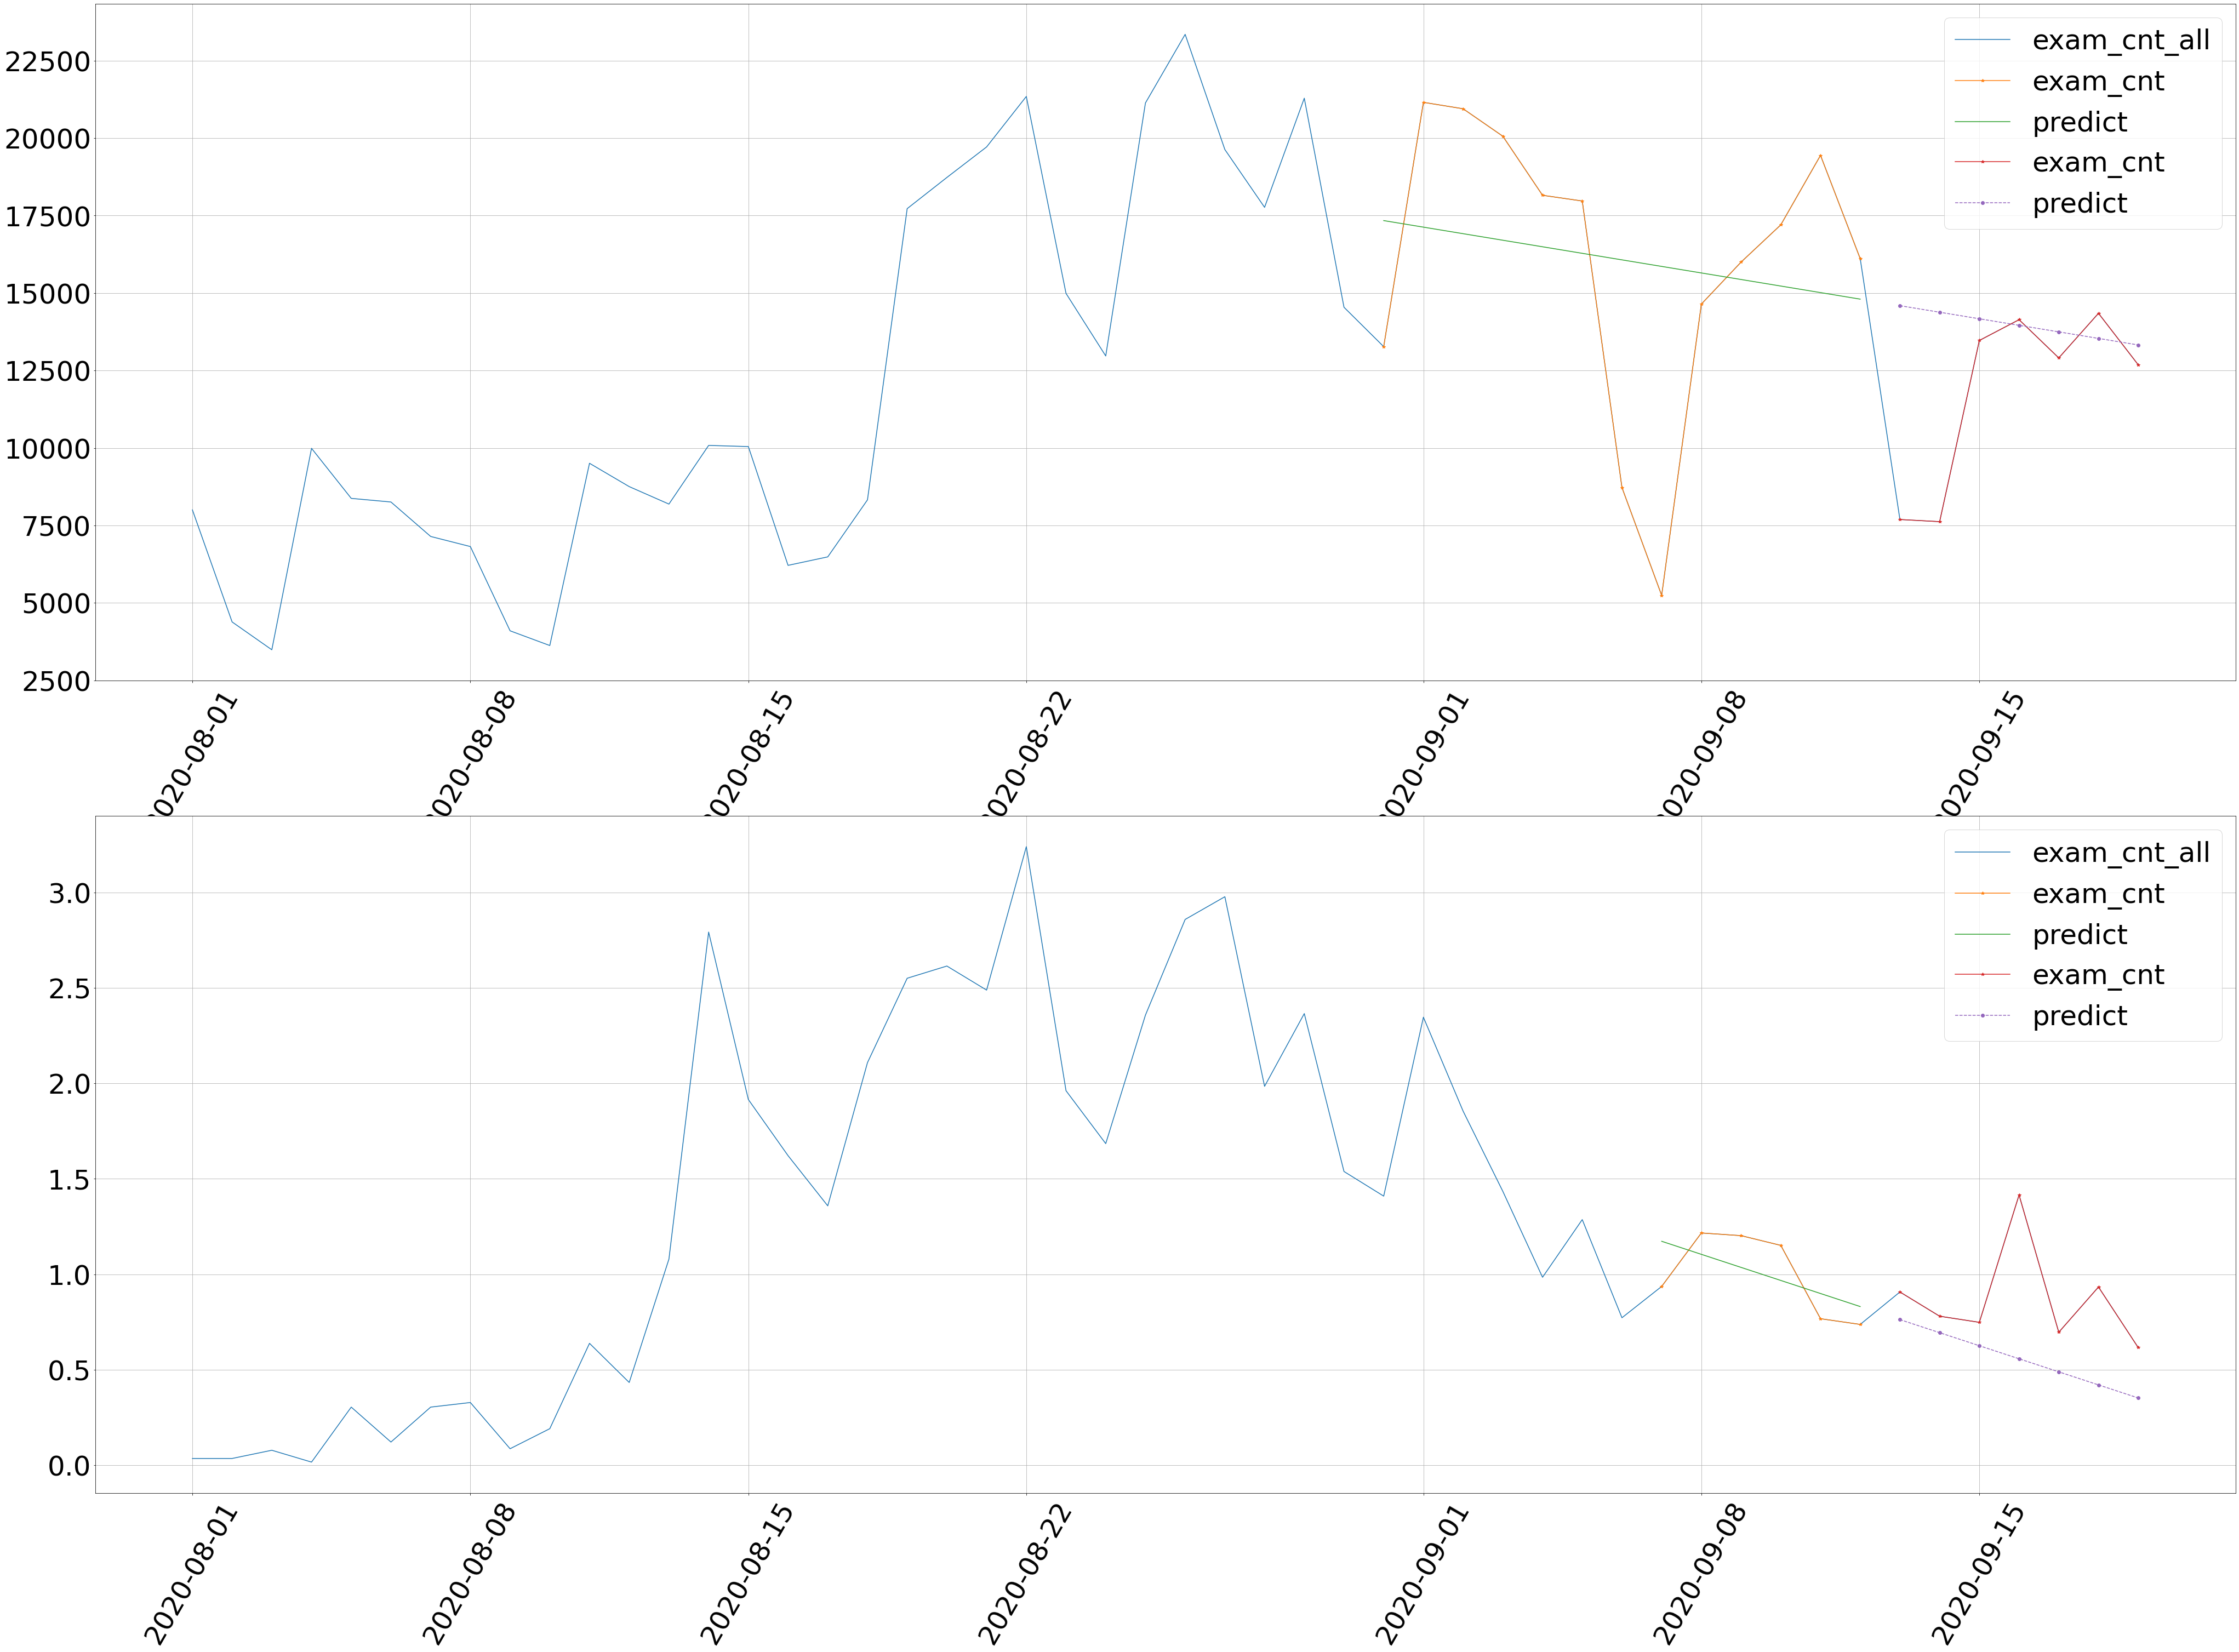

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [20]:
plt.figure(figsize=(70,50))


# exam
plt.subplot(211)
plt.plot(prd_data.loc['2020-08-01':,'exam_cnt'], label = 'exam_cnt_all')

plt.plot(exam_diff_data.index, exam_diff_data.exam_cnt, marker = '*', label='exam_cnt')
plt.plot(exam_diff_data.index, exam_diff_data.prd_exam_cnt, label='predict')

plt.plot(exam_prd_fit.index, exam_prd_fit.exam_cnt, marker = '*', label='exam_cnt')
plt.plot(exam_prd_fit.index, exam_prd_fit.prd_exam_cnt, marker = 'o',linestyle='--', label='predict')
plt.xticks(rotation=60,fontsize=50)
plt.yticks(fontsize=50)
plt.legend(fontsize=50)
plt.grid(b = True, axis='both')


# spread
plt.subplot(212)
plt.plot(prd_data.loc['2020-08-01':,'spread'], label = 'exam_cnt_all')

plt.plot(spread_diff_data.index, spread_diff_data.spread, marker = '*', label='exam_cnt')
plt.plot(spread_diff_data.index, spread_diff_data.prd_spread, label='predict')

plt.plot(spread_prd_fit.index, spread_prd_fit.spread, marker = '*', label='exam_cnt')
plt.plot(spread_prd_fit.index, spread_prd_fit.prd_spread, marker = 'o',linestyle='--', label='predict')
plt.xticks(rotation=60,fontsize=50)
plt.yticks(fontsize=50)
plt.legend(fontsize=50)
plt.grid(b = True, axis='both')

plt.show()
qgrid.show_grid(prd_data,show_toolbar=True)
# prd_data.index

 2. 전체 데이터 셋을 정규화 한다.

In [21]:
allX_scaler = scaler()
allY_scaler = scaler()
allP_scaler = scaler()

x_all = xy[:,:-1]
y_all = xy[:,[-1]]
prd_x_all = np.concatenate((xy[:,:-1],arr_prd),axis=0)

x_all_sc = allX_scaler.fit(x_all)
y_all_sc = allY_scaler.fit(y_all)
prd_x_all_sc = allP_scaler.fit(prd_x_all)

x_all = x_all_sc.transform(x_all)
y_all = y_all_sc.transform(y_all)
x_prd = prd_x_all_sc.transform(prd_x_all)

xy_sc = np.concatenate((x_all,y_all),axis = 1)

x_all , y_all = build_dataset(xy_sc,seq_length)
px_all = build_dataset_x(x_prd,seq_length)

px_all = px_all[-periods:]
px_all

0번째
[[0.00 0.01 0.00]
 [0.00 0.01 0.00]
 [0.00 0.01 0.00]
 [0.02 0.01 0.00]] -> [0.00]
1번째
[[0.00 0.01 0.00]
 [0.00 0.01 0.00]
 [0.02 0.01 0.00]
 [0.02 0.01 0.00]] -> [0.00]
2번째
[[0.00 0.01 0.00]
 [0.02 0.01 0.00]
 [0.02 0.01 0.00]
 [0.04 0.00 0.00]] -> [0.00]
3번째
[[0.02 0.01 0.00]
 [0.02 0.01 0.00]
 [0.04 0.00 0.00]
 [0.08 0.01 0.00]] -> [0.01]
4번째
[[0.02 0.01 0.00]
 [0.04 0.00 0.00]
 [0.08 0.01 0.00]
 [0.13 0.02 0.00]] -> [0.05]
5번째
[[0.04 0.00 0.00]
 [0.08 0.01 0.00]
 [0.13 0.02 0.00]
 [0.21 0.03 0.00]] -> [0.07]
6번째
[[0.08 0.01 0.00]
 [0.13 0.02 0.00]
 [0.21 0.03 0.00]
 [0.19 0.11 0.00]] -> [0.07]
7번째
[[0.13 0.02 0.00]
 [0.21 0.03 0.00]
 [0.19 0.11 0.00]
 [0.27 0.09 0.00]] -> [0.04]
8번째
[[0.21 0.03 0.00]
 [0.19 0.11 0.00]
 [0.27 0.09 0.00]
 [0.32 0.06 0.00]] -> [0.07]
9번째
[[0.19 0.11 0.00]
 [0.27 0.09 0.00]
 [0.32 0.06 0.00]
 [0.55 0.09 0.00]] -> [0.10]
10번째
[[0.27 0.09 0.00]
 [0.32 0.06 0.00]
 [0.55 0.09 0.00]
 [0.54 0.11 0.00]] -> [0.06]
0번째
[[0.00 0.01 0.00]
 [0.00 0.01 0.00]
 [

array([[[0.60, 0.44, 0.80],
        [0.55, 0.21, 0.80],
        [0.61, 0.29, 0.80],
        [0.54, 0.19, 0.80]],

       [[0.55, 0.21, 0.80],
        [0.61, 0.29, 0.80],
        [0.54, 0.19, 0.80],
        [0.56, 0.09, 0.80]],

       [[0.61, 0.29, 0.80],
        [0.54, 0.19, 0.80],
        [0.56, 0.09, 0.80],
        [0.55, 0.06, 0.80]],

       [[0.54, 0.19, 0.80],
        [0.56, 0.09, 0.80],
        [0.55, 0.06, 0.80],
        [0.54, 0.04, 0.80]],

       [[0.56, 0.09, 0.80],
        [0.55, 0.06, 0.80],
        [0.54, 0.04, 0.80],
        [0.53, 0.02, 0.80]]])

2. 예측할 날을 설정하고 , 예측을 실행한다.

In [22]:
y_prd = tf.model.predict(px_all)
prd_val = list(y_all_sc.inverse_transform(y_prd).astype(np.int).flatten())
prd_val

[40, 29, 23, 15, 8]

3. 모델 예측 결과 및 시각화

DatetimeIndex(['2020-09-20', '2020-09-21', '2020-09-22', '2020-09-23',
               '2020-09-24'],
              dtype='datetime64[ns]', freq='D')


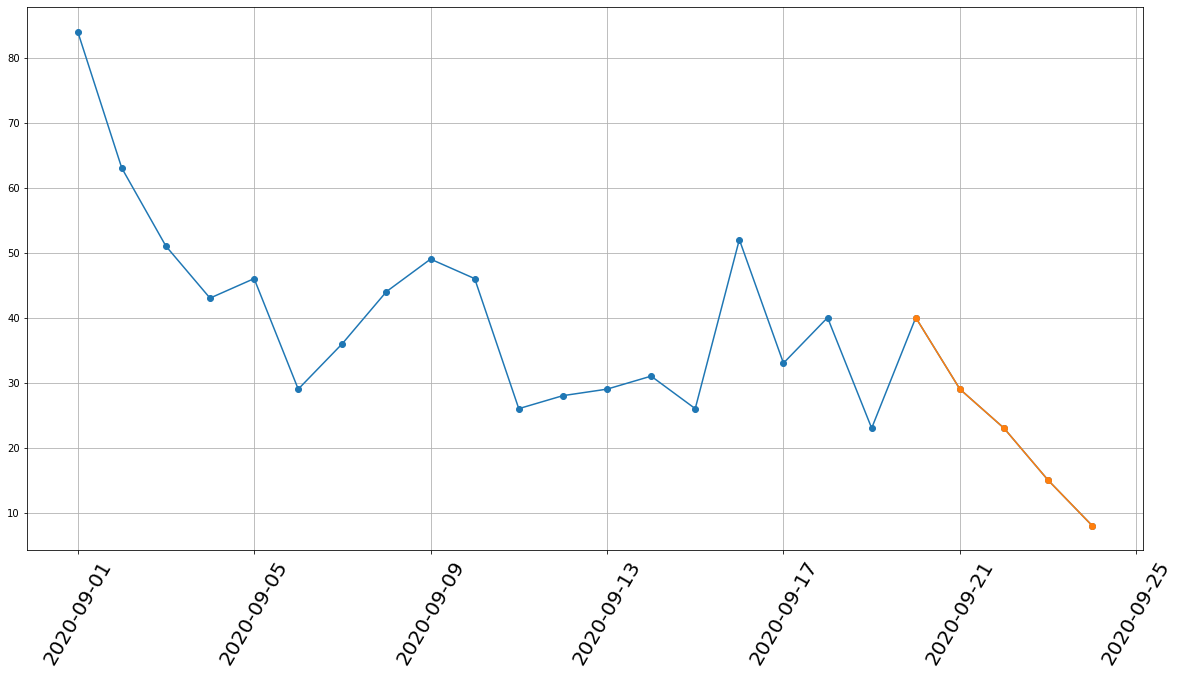

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [23]:
arr_prd_day = np.concatenate((arr_prd,np.array(prd_val).reshape(-1,1)),axis=1)
prd_idx = pd.date_range(start= prd_data.index[-1], periods= periods + 1, closed='right')
df_prd_day = pd.DataFrame(arr_prd_day,index=prd_idx,columns=data_col)

df_all = pd.concat([prd_data,df_prd_day])
print(prd_idx)
plt.figure(figsize=(20,10))
plt.plot(df_all.loc['2020-09-01':,'cfm_cnt'],marker='o')
plt.plot(df_prd_day.index,df_prd_day.cfm_cnt,marker = 'o')
plt.grid(b=True,axis='both')
plt.xticks(rotation = 60, fontsize=20)
plt.show()
qgrid.show_grid(df_prd_day,show_toolbar=True)